## Equity Pairs Trading

In [1]:
import numpy as np
import pandas as pd
import math
import statistics
import yfinance as yf
from datetime import date
from pandas_datareader import data
import matplotlib.pyplot as plt 
import seaborn as sns
from yahoo_fin import stock_info as si
from scipy.spatial.distance import cdist

In [2]:
def get_data(stocklist,start,end):
    '''
    stocklist: List: list of string tickers
    start: start date of the data '%Y-%m-%d'
    end: start date of the data '%Y-%m-%d'
    
    Downloads data from stocklist provided. 
    All the prices are divided by the start date of price history to normalize and fit it in the framework of pairs generation
    
    '''
    data = pd.DataFrame(columns = stocklist)
    df = pd.DataFrame(columns = ['AdjClose'])
    for ticker in stocklist:
        df['AdjClose'] = yf.download(ticker, interval = '1d',start = start_date,end = end_date,progress = False)['Adj Close']
        data[ticker] = df['AdjClose']
    data = data.dropna(axis = 1)
    return data


class PairFormation():
    
    def __init__(self,data_df,num_pairs):
        self.data_df = data_df
        self.num_pairs = num_pairs
        
    
    def unrestrictedpairs(self):    
        '''
        data_df: pandas dataframe: from get_data() function
        num_pairs: int : number of best pairs to be formed

        Takes data from the get_data() function and processes it to generate pairs based on the Sum of squared Deviations (SSD) of the 
        share price ratios. It is unrestricted as it does not take into consideration the particular sector a stock belongs to.
        The pairs are formed based on the least SSD and top num_pairs are returned

        '''

        data = self.data_df[:]
        data = data/data.iloc[0]
        #data = np.log(data/data.iloc[0])        
        dist_df = pd.DataFrame(cdist(np.asarray(data).T,np.asarray(data).T)**2)
        dist_df.columns = data.columns
        dist_df.index = data.columns

        dist_df = dist_df.apply(pd.to_numeric)
        dist_df = dist_df.replace(to_replace = 0, value = np.nan)
        pair = pd.DataFrame(dist_df.idxmin(axis = 1),columns = ['pair'])
        value = pd.DataFrame(dist_df.min(axis = 1),columns = ['distance'])
        pair = pair.join(value,how = 'outer').reset_index().rename(columns = {'index': 'bestpair'})
        pair['pair'] = list(zip(pair.pair, pair.bestpair))
        pair = pair[['pair','distance']]
        pair = pair.drop_duplicates(subset = 'distance')
        pair = pair.sort_values(by = 'distance').reset_index()[['pair','distance']][:self.num_pairs]

        return pair

def signal(s,threshold,pair,stoploss):
    """
    Main signal generator: Takes threshold, stoploss and gives us signla whether to go long/short the secturity
    """
    if pair == 1:
        if (s > threshold and  s < stoploss):
            s = 1
        elif (s < -threshold and s > -stoploss):
            s = -1
        else:
            s = 0
    else:
        if (s > threshold and s < stoploss):
            s = -1
        elif (s < -threshold and s > -stoploss):
            s = 1   
        else:
            s = 0
    return s

def max_drawdown_absolute(returns):
    """
    Calculates Maximum drawdown
    """
    r = returns.add(1).cumprod()
    dd = r.div(r.cummax()).sub(1)
    mdd = dd.min()
    return mdd

In [3]:
stocklist = si.tickers_dow() #Dow Jones Tickers
start_date = '2018-01-01'
end_date = '2020-01-01'
data = get_data(stocklist,start=start_date,end=end_date)
pair_formation_start_date = '2018-01-01'
pair_formation_end_date = '2019-01-01'
pair_formation = PairFormation(data[pair_formation_start_date:pair_formation_end_date],5)
pairs = pair_formation.unrestrictedpairs()
print(pairs)

         pair  distance
0    (V, NKE)  0.279209
1   (V, MSFT)  0.299456
2    (VZ, KO)  0.334582
3  (JNJ, DIS)  0.384529
4  (JNJ, MCD)  0.480312


Top 5 pairsfor the given period are calculated and the first pair is choden for the analysis. The pairs are formed based on the least Sum of Squared Deviations and top 5 are returned

Cointegration approach is performed on these top pairs. We need not calculate the SSD if we are using the cointegration approach, but to filter out the top performing pairs, I have used the SSD method and now checking whether they are cointegrated or not. Statistical inference rather than intuition in selecting the pairs

The top pair is selected and analysis is performed on this top pair

## Cointegration approach

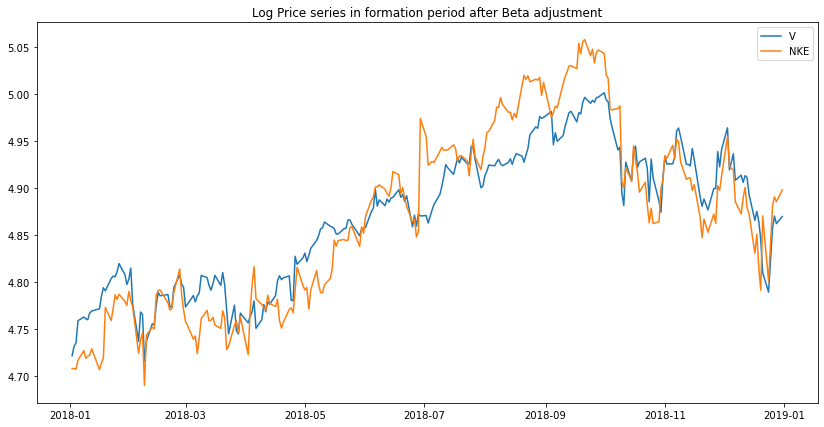

In [10]:
log_prices = np.log(data[[pairs.loc[0][0][0],pairs.loc[0][0][1]]])['2018-01-02':'2019-01-01']
columns = log_prices.columns
y = np.array(log_prices[columns[0]])
X = np.array(log_prices[columns[1]]).reshape(1,-1).T
beta = np.matmul(np.matmul(np.linalg.inv(np.matmul(X.T,X)),X.T),y)[0] #Beta estimation (Regression analysis)
plt.figure(figsize = (14,7))
plt.title('Log Price series in formation period after Beta adjustment')
plt.plot(log_prices[columns[0]])
plt.plot(log_prices[columns[1]]*beta)
plt.legend([pairs.loc[0][0][0],pairs.loc[0][0][1]])

## Trading Period: 2019- (2019 + x days)

In [5]:
def backtest(start_period,end_period,threshold,stoploss,data,pairs,log_prices):
    """
    Main Backtest function. Need to define the start date, end date, the stoploss, data, log_prices of the data
    Returns Returns of the pairs-trading strategy, sharpe ratio, Max drawdown
    """
    trading_period_data = np.log(data[[pairs.loc[0][0][0],pairs.loc[0][0][1]]])[start_period:end_period]
    trading_period_data['residuals'] = trading_period_data[log_prices.columns[0]] - beta*trading_period_data[log_prices.columns[1]] 
    log_prices['residuals'] =  log_prices[log_prices.columns[0]] - beta*log_prices[log_prices.columns[1]] 
    pairs_formation_period_vol = log_prices.residuals.std()
    trading_period_data['z'] = trading_period_data['residuals']/pairs_formation_period_vol
    trading_period_data[log_prices.columns[0] + ' Signal'] = trading_period_data['z'].apply(signal,threshold = threshold,pair = 1,stoploss = stoploss)
    trading_period_data[log_prices.columns[1] + ' Signal'] = trading_period_data['z'].apply(signal,threshold = threshold,pair = 2,stoploss =stoploss)
    trading_period_data[log_prices.columns[0] + " Returns"] = trading_period_data[log_prices.columns[0]].diff()
    trading_period_data[log_prices.columns[1] + " Returns"] = trading_period_data[log_prices.columns[1]].diff()
    trading_period_data['Strategy Returns'] = ((trading_period_data[log_prices.columns[0] + " Returns"].shift(1))*trading_period_data[log_prices.columns[0] + ' Signal']) + ((trading_period_data[log_prices.columns[1] + " Returns"].shift(1))*trading_period_data[log_prices.columns[1] + ' Signal'])
    sharpe = (np.nan_to_num(trading_period_data['Strategy Returns']).mean()/np.nan_to_num(trading_period_data['Strategy Returns']).std())*math.sqrt(255)
    mdd = max_drawdown_absolute(trading_period_data['Strategy Returns'])
    return trading_period_data,sharpe,mdd

In [6]:
#Insample
#Tuning spread threshold trigger and stoploss to get the best results- Insample hypermarameter tuning
i = 0
results = pd.DataFrame(columns = ['Threshold','Stoploss','SharpeRatio',"Max Drawdown"])
for threshold in [0.25,0.5,0.75,1,1.25]:
    for stoploss in [2,2.5,3,3.5]:
        strat,sharpe,mdd = backtest('2018-01-01','2019-01-01',threshold,stoploss,data,pairs,log_prices)
        #plt.figure(figsize = (14,7))
        #plt.title('Cumulative Returns in Trading Period')
        #plt.plot(np.cumprod(1+strat['Strategy Returns'])-1)
        #plt.show()
        results.loc[i] = [threshold,stoploss,sharpe,mdd]
        i+=1

In [7]:
results

,Threshold,Stoploss,SharpeRatio,Max Drawdown
0,0.25,2.0,0.680205,-0.130857
1,0.25,2.5,1.100823,-0.126008
2,0.25,3.0,1.192230,-0.099792
3,0.25,3.5,1.192230,-0.099792
4,0.50,2.0,0.759976,-0.119529
5,0.50,2.5,1.226356,-0.112437
6,0.50,3.0,1.330255,-0.099792
7,0.50,3.5,1.330255,-0.099792
8,0.75,2.0,0.911549,-0.102789
9,0.75,2.5,1.384221,-0.103486


In [8]:
#Getting the best hyperparameters- For using these parameters in the out-of -sample period
results.loc[results['SharpeRatio'].idxmax()]

Threshold       1.000000
Stoploss        3.000000
SharpeRatio     1.536387
Max Drawdown   -0.065250
Name: 14, dtype: float64

z spread threshold 1.0 (entry point) and stoploss z = 3.0 seem like the best hyperparameters.
Testing it on out-of-sample gives the following

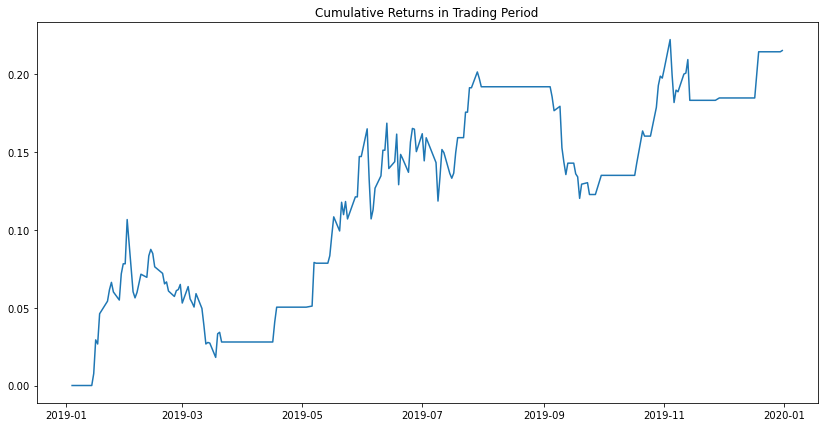

Sharpe Ratio is  1.5123269388909322
Max Drawdown is  -0.07999481188085256


In [9]:
#Out of sample (Next 1 year data is considered for ou-of-sample results)
strat,sharpe,mdd = backtest('2019-01-01','2020-01-01',results.loc[results['SharpeRatio'].idxmax()]['Threshold'],results.loc[results['SharpeRatio'].idxmax()]['Stoploss'],data,pairs,log_prices)
plt.figure(figsize = (14,7))
plt.title('Cumulative Returns in Trading Period')
plt.plot(np.cumprod(1+strat['Strategy Returns'])-1)
plt.show()
print("Sharpe Ratio is ",sharpe)
print('Max Drawdown is ',mdd)

In [11]:
#Sensitivity testing of out-of sample data by slightly changing the hyperpaprameters close to best hyperparameters
i = 0
results = pd.DataFrame(columns = ['Threshold','Stoploss','SharpeRatio',"Max Drawdown"])
for threshold in [0.85,0.9,0.95,1,1.05,1.1,1.15]:
    for stoploss in [2.8,2.9,3,3.1,3.2]:
        strat,sharpe,mdd = backtest('2019-01-01','2020-01-01',threshold,stoploss,data,pairs,log_prices)
        #plt.figure(figsize = (14,7))
        #plt.title('Cumulative Returns in Trading Period')
        #plt.plot(np.cumprod(1+strat['Strategy Returns'])-1)
        #plt.show()
        results.loc[i] = [threshold,stoploss,sharpe,mdd]
        i+=1

In [12]:
results

,Threshold,Stoploss,SharpeRatio,Max Drawdown
0,0.85,2.8,1.240462,-0.093490
1,0.85,2.9,1.183803,-0.095177
2,0.85,3.0,1.757456,-0.079995
3,0.85,3.1,1.547070,-0.079995
4,0.85,3.2,1.602312,-0.085058
5,0.90,2.8,1.081157,-0.093490
6,0.90,2.9,1.025761,-0.095177
7,0.90,3.0,1.607419,-0.079995
8,0.90,3.1,1.397476,-0.079995
9,0.90,3.2,1.454490,-0.085058
